# Sample1 차선 값만 이산적으로 뽑아내기
### 대상 차량: vehicle0, vehicle1, vehicle8

lane intersections structure  
* key: vehicle num  
* val[i][0]: frame num  
* val[i][1]: vehicle 좌표  
* val[i][2:]: vehicle 좌표에서 수평선을 그었을 때 차선과의 교점  
모든 좌표는 lane net 결과 기준 (512, 256)

depth_map_list
* 150개의 이미지에 대한 1080 * 1920 픽셀의 depth map 값이 3중 리스트로 만들어져 있음

In [31]:
import json
import numpy as np
import os

with open('result.json', 'r') as file:
    lane_intersections = json.load(file)
print(lane_intersections)

def load_npy_files(directory):
    npy_files = [f for f in os.listdir(directory) if f.endswith('metric_depth.npy')]
    data_list = []
    for file in npy_files:
        data = np.load(os.path.join(directory, file))
        data_list.append(data)
    return data_list

directory_path = 'content/object_depths'
depth_map_list = load_npy_files(directory_path)

{'vehicle0': [[0, [118, 280], [118, 237.0], [118, 266.5], [118, 289.5]], [1, [118, 280], [118, 236.5], [118, 266.0], [118, 289.5]], [2, [119, 280], [119, 236.5], [119, 267.0], [119, 291.5]], [3, [119, 281], [119, 235.5], [119, 268.0], [119, 292.0]], [5, [119, 281], [119, 234.0], [119, 267.5], [119, 291.0]], [6, [119, 282], [119, 235.0], [119, 265.5], [119, 290.0]], [7, [119, 282], [119, 236.5], [119, 265.0], [119, 292.5]], [8, [119, 283], [119, 236.5], [119, 266.5], [119, 292.5]], [9, [119, 283], [119, 237.5], [119, 267.5], [119, 291.0]], [10, [119, 283], [119, 236.0], [119, 267.0], [119, 290.0]], [11, [119, 284], [119, 235.0], [119, 268.0], [119, 292.5]], [12, [119, 284], [119, 230.0], [119, 266.5], [119, 290.5]], [13, [119, 285], [119, 233.5], [119, 267.0], [119, 291.5]], [14, [119, 285], [119, 229.0], [119, 266.0], [119, 291.0]], [15, [119, 285], [119, 225.5], [119, 267.5], [119, 293.0]], [17, [119, 286], [119, 234.0], [119, 266.5], [119, 292.5]], [18, [119, 287], [119, 234.5], [119

In [32]:
# resizing 
lheight, lwidth =  256, 512 # lane net size
dheight, dwidth = depth_map_list[0].shape # depth map size

print(f"lanenet size: {lheight, lwidth}")
print(f"depth map size: {dheight, dwidth}")

resizing_val = dheight/lheight, dwidth/lwidth
print(f"resizing value: {resizing_val}")

lanenet size: (256, 512)
depth map size: (1080, 1920)
resizing value: (4.21875, 3.75)


In [33]:
for vehicle, values in lane_intersections.items():
    print(f"{vehicle}: {len(values)}")
    for value in values:
        for points in value[1:]:
            points[0] *= resizing_val[0]
            points[1] *= resizing_val[1]

vehicle0: 117
vehicle1: 77
vehicle8: 31


In [34]:
fx, fy, cx, cy = 1316.81, 738.72, 960, 540
def get_3dpoint(frame_num, v, u):
    depth = depth_map_list[frame_num]
    d = depth[v,u]
    Z = d
    X = (v - cx) * Z / fx
    Y = (u - cy) * Z / fy
    return [X, Y, Z]

### 교점 확인  
이미지에 교점 직접 찍어봄

In [35]:
idx=0
print(lane_intersections.keys())
vehicle = 'vehicle0'

dict_keys(['vehicle0', 'vehicle1', 'vehicle8'])


1
497 1050
[-18.70068379868272, 36.71892269320539, 53.18627955279351]
497 886
[-16.285436395702664, 21.69390666020966, 46.31711771106959]
497 997
[-12.08412385877846, 21.261487029237877, 34.36824003990942]
497 1085
[-21.100687036914255, 44.27467339135702, 60.012085738831665]


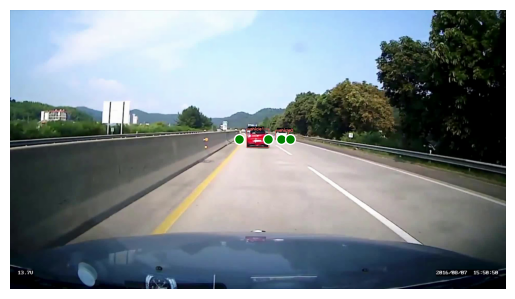

In [36]:
import random
import cv2
import matplotlib.pyplot as plt
#idx = random.randint(0, tracking_len-1)
#print(idx)

idx += 1
print(idx)

frame_num = lane_intersections[vehicle][idx][0]
img_path = f'content/tracker/{frame_num:06d}.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

for point in lane_intersections[vehicle][idx][1:]:
    v, u = int(point[0]), int(point[1])
    plt.scatter([u], [v], color='green', s=50, edgecolor='white')
    print(v, u)
    print(get_3dpoint(frame_num, v, u))

plt.axis('off')
plt.show()

In [37]:
# vehicle당 모든 [frame_num, vehicle coor, lane coors] 계산
# depth map size: (1080, 1920)
realworld_values = {}
for vehicle, values in lane_intersections.items():
    points3d = []
    for value in values:
        frame_num = value[0]
        point3d = [frame_num]
        for points in value[1:]:
            point3d.append(get_3dpoint(frame_num, int(points[0]), int(points[1])))
        points3d.append(point3d)
    realworld_values[vehicle] = points3d

차선이 여러 개 있을 때, 차선 사이 폭이 모두 똑같다고 가정  
frame마다 value가 있고, 차선 사이 폭의 평균 계산 -> average_width    
계산된 frame당 평균 차선 폭의 평균을 구함  


In [38]:
# lane width 계산
lane_widths_dict = {}

for vehicle, values in realworld_values.items():
    all_widths = []
    for frame_value in values:
        lane_num = len(frame_value)-2
        frame_widths = []
        # 차선의 좌표들로 차선 폭 계산
        for idx in range(lane_num-1):
            frame_width = np.linalg.norm(np.array(frame_value[idx+2]) - np.array(frame_value[idx+3])) # frame num, vehicle coor 제외  
            frame_widths.append(frame_width)
        all_widths.append(np.mean(frame_widths))
    lane_widths_dict[vehicle] = np.mean(all_widths)

In [39]:
from scipy.stats import mode
import numpy as np

# lane width 계산
lane_widths_dict = {}

for vehicle, values in realworld_values.items():
    all_widths = []
    for frame_value in values:
        lane_num = len(frame_value) - 2
        # 차선의 좌표들로 차선 폭 계산
        for idx in range(lane_num - 1):
            frame_width = np.linalg.norm(np.array(frame_value[idx+2]) - np.array(frame_value[idx+3])) # frame num, vehicle coor 제외
            all_widths.append(frame_width)
    
    # all_widths에서 최빈값 계산
    if len(all_widths) > 0:
        mode_result = mode(all_widths)
        print(vehicle, mode_result)
        print(mode_result)  # mode_result의 구조를 확인합니다
        if mode_result.mode.size > 0:  # mode_result.mode가 빈 배열이 아닌지 확인
            lane_widths_dict[vehicle] = mode_result.mode
        else:
            lane_widths_dict[vehicle] = None  # 최빈값이 없는 경우 처리
    else:
        lane_widths_dict[vehicle] = None  # 데이터가 없는 경우 처리

vehicle0 ModeResult(mode=4.712286496076135, count=1)
ModeResult(mode=4.712286496076135, count=1)
vehicle1 ModeResult(mode=4.877310855624132, count=1)
ModeResult(mode=4.877310855624132, count=1)
vehicle8 ModeResult(mode=7.388800772081441, count=1)
ModeResult(mode=7.388800772081441, count=1)


In [40]:
lane_widths_dict
valid_values = [value for value in lane_widths_dict.values() if value is not None]
lane_width = np.median(valid_values)


for i in lane_widths_dict.keys():
    if lane_widths_dict[i]==None:
        lane_widths_dict[i]=lane_width

차량 위치 계산  
1. 차량이 차선 사이에 위치 : 차량 x좌표가 min도 아니고 max도 아님    
2. 차량이 가장자리에 위치 : 차량 x좌표가 min혹은 max  

In [41]:
lane_ratios = {}
for vehicle, values in lane_intersections.items():
    vehicle_lane_ratios = []
    for value in values:
        frame_num = value[0]
        x = sorted(value[1:], key=lambda x: x[1])
        for vehicle_idx in range(len(x)):
            if value[1][1] == x[vehicle_idx][1]:
                break
        if vehicle_idx==0:
            # 차량이 왼쪽 끝에 위치
            if (len(x)<=1):
                continue

            else :
                lane1 = get_3dpoint(frame_num, int(x[vehicle_idx+1][0]), int(x[vehicle_idx+1][1]))
                vehicle_point = get_3dpoint(frame_num, int(value[1][0]), int(value[1][1]))

                lane_width = lane_widths_dict[vehicle]
                ratio2 = np.linalg.norm(np.array(vehicle_point) - np.array(lane1)) / lane_width
                ratio1 = 1-ratio2

                if ratio1 < 0 or ratio2 < 0:
                    print(f"{vehicle} {frame_num}: ratio1={ratio1}, ratio2={ratio2}/ {lane_width}")

                vehicle_lane_ratios.append([frame_num, vehicle_idx, ratio1, ratio2])

        elif vehicle_idx==len(x)-1:

            # 차량이 오른쪽 끝에 위치
            lane1 = get_3dpoint(frame_num, int(x[vehicle_idx-1][0]), int(x[vehicle_idx-1][1]))
            vehicle_point = get_3dpoint(frame_num, int(value[1][0]), int(value[1][1]))

            lane_width = lane_widths_dict[vehicle]
            ratio1 = np.linalg.norm(np.array(vehicle_point) - np.array(lane1)) / lane_width
            ratio2 = 1-ratio1

            if ratio1 < 0 or ratio2 < 0:
                print(f"{vehicle} {frame_num}: ratio1={ratio1}, ratio2={ratio2}/ {lane_width}")

            vehicle_lane_ratios.append([frame_num, vehicle_idx, ratio1, ratio2])

        else:

            lane1 = get_3dpoint(frame_num, int(x[vehicle_idx-1][0]), int(x[vehicle_idx-1][1]))
            lane2 = get_3dpoint(frame_num, int(x[vehicle_idx+1][0]), int(x[vehicle_idx+1][1]))
            vehicle_point = get_3dpoint(frame_num, int(value[1][0]), int(value[1][1]))

            lane_width = np.linalg.norm(np.array(lane2) - np.array(lane1))
            ratio1 = np.linalg.norm(np.array(vehicle_point) - np.array(lane1)) / lane_width
            ratio2 = np.linalg.norm(np.array(lane2) - np.array(vehicle_point)) / lane_width
            
            ratio_sum = ratio1+ratio2
            ratio1 = ratio1/ratio_sum
            ratio2 = ratio2/ratio_sum
            if ratio1 < 0 or ratio2 < 0:
                print(f"{vehicle} {frame_num}: ratio1={ratio1}, ratio2={ratio2}/ {lane_width}")

            vehicle_lane_ratios.append([frame_num, vehicle_idx, ratio1, ratio2])
    lane_ratios[vehicle] = vehicle_lane_ratios
        

vehicle0 44: ratio1=1.7694544926555151, ratio2=-0.7694544926555151/ 4.712286496076135
vehicle0 45: ratio1=1.9629850411711987, ratio2=-0.9629850411711987/ 4.712286496076135
vehicle0 47: ratio1=2.078155537940404, ratio2=-1.078155537940404/ 4.712286496076135
vehicle0 48: ratio1=2.0303314811584774, ratio2=-1.0303314811584774/ 4.712286496076135
vehicle0 49: ratio1=1.6809111247751223, ratio2=-0.6809111247751223/ 4.712286496076135
vehicle0 50: ratio1=1.3563974589674523, ratio2=-0.35639745896745234/ 4.712286496076135
vehicle0 51: ratio1=1.0609316083568432, ratio2=-0.06093160835684319/ 4.712286496076135
vehicle0 52: ratio1=1.1359417095542894, ratio2=-0.1359417095542894/ 4.712286496076135


### 비율 음수인 경우 주변값의 평균값으로 값 대체
값이 음수이거나 lanewidth보다 큰 값일 경우 주변값들의 평균값으로 대체해주었다.

In [42]:

for key, items in lane_ratios.items():
    for i in range(len(lane_ratios[key])):
        if lane_ratios[key][i][2]<0 or lane_ratios[key][i][2]>1:
            index_1=0
            index_2=0
            if i==0:    
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][2]<1:
                        index_1=index_2=j
                        break
            elif i==len(lane_ratios[key])-1:
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][2]<1:
                        index_1=index_2=j
                        break
            else:
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][2]<1:
                        index_1=j
                        break
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][2]<1:
                        index_2=j
                        break
            lane_ratios[key][i][2] = (lane_ratios[key][index_1][2] + lane_ratios[key][index_2][2])/2

        if lane_ratios[key][i][3]<0 or lane_ratios[key][i][3]>1:
            index_1=0
            index_2=0
            if i==0:
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][3]<1:
                        index_1=index_2=j
                        break
            elif i==len(lane_ratios[key])-1:
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][3]<1:
                        index_1=index_2=j
                        break
            else:
                for j in range(i,len(lane_ratios[key])):
                    if 0<lane_ratios[key][j][3]<1:
                        index_1=j
                        break
                for j in range(i-1,0,-1):
                    if 0<lane_ratios[key][j][3]<1:
                        index_2=j
                        break
            lane_ratios[key][i][3] = (lane_ratios[key][index_1][3] + lane_ratios[key][index_2][3])/2    
        


### 값이 음수가 나오는 차량 찍어보기

In [43]:
for key, items in lane_ratios.items():
    for i in range(len(lane_ratios[key])):
        if lane_ratios[key][i][2]<0 or lane_ratios[key][i][3]<0:
            print(key,": ",lane_ratios[key][i][2], lane_ratios[key][i][3]) 

### vehicel 0, vehicle 1, vehicle8의 정보에 집중

In [44]:
filtered_lane_ratios = {
    "vehicle0": lane_ratios.get("vehicle0"),
    "vehicle1": lane_ratios.get("vehicle1"),
    "vehicle8": lane_ratios.get("vehicle8")
}

### lane_position을 json 파일로 저장

In [45]:
import json
file_path = 'lane_ratio.json'
with open(file_path, 'w', encoding='utf-8') as json_file:
            json.dump(lane_ratios, json_file, ensure_ascii=False, indent=4)

### 차선별로 비율을 스무딩하고 그래프 그리기

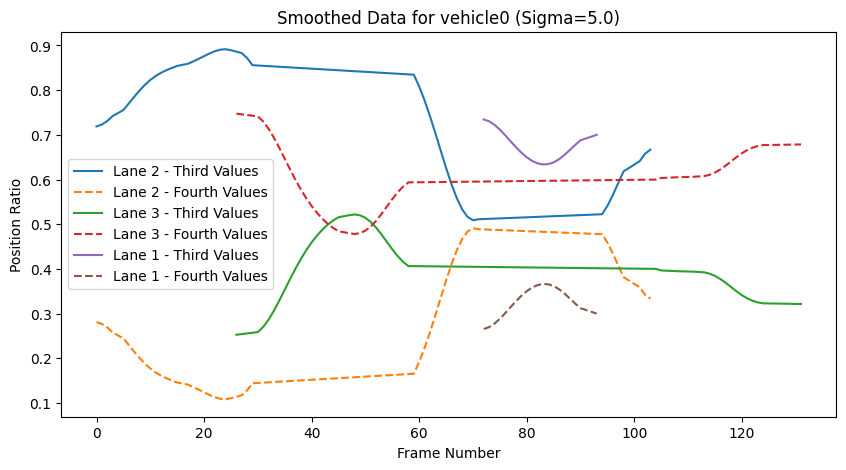

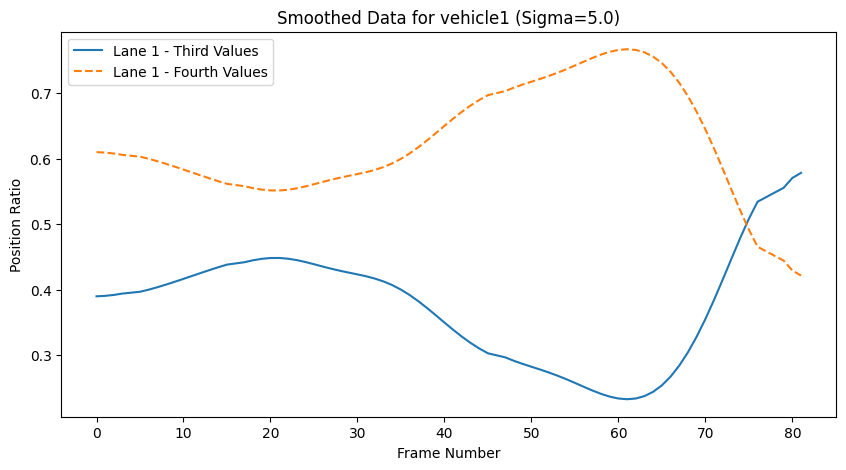

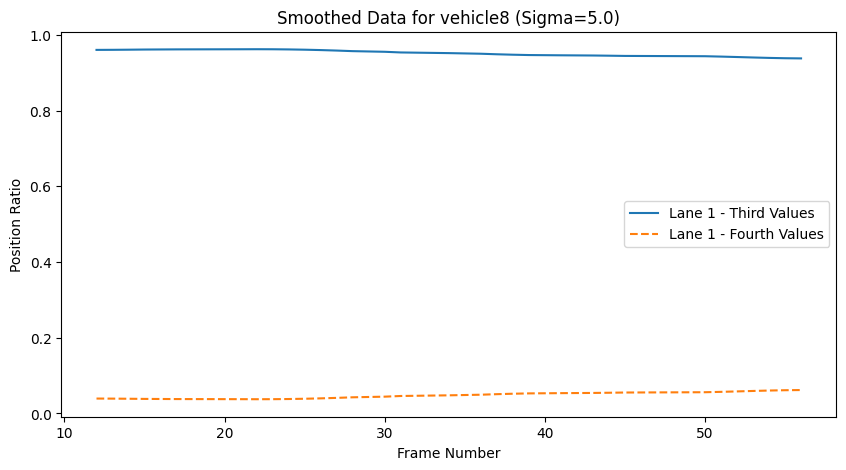

In [46]:
import json
import numpy as np
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

# JSON 파일 경로
input_file_path = 'lane_ratio.json'
output_file_path = 'lane_ratio_smoothed.json'

# 가우시안 필터의 표준 편차 (sigma)
sigma = 5.0

def apply_gaussian_smoothing(vehicle_data, sigma):
    # 차선별로 데이터 그룹화
    lane_groups = {}
    for frame in vehicle_data:
        lane_id = frame[1]
        if lane_id not in lane_groups:
            lane_groups[lane_id] = {'frames': [], 'third_values': [], 'fourth_values': []}
        lane_groups[lane_id]['frames'].append(frame[0])
        lane_groups[lane_id]['third_values'].append(frame[2])
        lane_groups[lane_id]['fourth_values'].append(frame[3])

    # 각 차선에 대해 가우시안 스무딩 적용
    for lane_id, lane_data in lane_groups.items():
        smoothed_third_values = gaussian_filter1d(lane_data['third_values'], sigma=sigma)
        smoothed_fourth_values = gaussian_filter1d(lane_data['fourth_values'], sigma=sigma)
        
        # 스무딩된 값을 원래 데이터에 반영
        for i, frame in enumerate(vehicle_data):
            if frame[1] == lane_id:
                frame[2] = smoothed_third_values[lane_data['frames'].index(frame[0])]
                frame[3] = smoothed_fourth_values[lane_data['frames'].index(frame[0])]

# JSON 파일 읽기
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# 각 차량에 대해 가우시안 스무딩 적용
for vehicle in data:
    apply_gaussian_smoothing(data[vehicle], sigma)

# 스무딩된 데이터를 새로운 JSON 파일로 저장
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

# 그래프 그리기 함수
def plot_smoothed_data(vehicle_data, vehicle_name):
    # 차선별로 데이터를 그룹화하여 그래프 생성
    lane_groups = {}
    for frame in vehicle_data:
        lane_id = frame[1]
        if lane_id not in lane_groups:
            lane_groups[lane_id] = {'frames': [], 'third_values': [], 'fourth_values': []}
        lane_groups[lane_id]['frames'].append(frame[0])
        lane_groups[lane_id]['third_values'].append(frame[2])
        lane_groups[lane_id]['fourth_values'].append(frame[3])

    plt.figure(figsize=(10, 5))
    
    for lane_id, lane_data in lane_groups.items():
        plt.plot(lane_data['frames'], lane_data['third_values'], label=f'Lane {lane_id} - Third Values')
        plt.plot(lane_data['frames'], lane_data['fourth_values'], label=f'Lane {lane_id} - Fourth Values', linestyle='--')

    # 그래프 제목 및 레이블 설정
    plt.title(f'Smoothed Data for {vehicle_name} (Sigma={sigma})')
    plt.xlabel('Frame Number')
    plt.ylabel('Position Ratio')
    plt.legend()

    # 그래프 보여주기
    plt.show()

# 각 차량에 대해 그래프 출력
for vehicle in data:
    plot_smoothed_data(data[vehicle], vehicle)


### 빈값 채우기

In [47]:
import json
import numpy as np

# JSON 파일 경로
input_file_path = 'lane_ratio_smoothed.json'
output_file_path = 'lane_ratio_filled.json'

def fill_missing_frames(vehicle_data):
    if not vehicle_data:
        # vehicle_data가 빈 리스트일 경우 처리하지 않음
        return
    
    # 프레임 번호를 가져와서 누락된 프레임을 찾습니다.
    frames = [frame[0] for frame in vehicle_data]
    min_frame, max_frame = min(frames), max(frames)
    all_frames = set(range(min_frame, max_frame + 1))
    missing_frames = sorted(all_frames - set(frames))
    
    # 누락된 프레임에 대해 주변값을 사용하여 채웁니다.
    for missing_frame in missing_frames:
        # 채울 값들을 찾습니다.
        prev_frame = max([frame for frame in frames if frame < missing_frame], default=None)
        next_frame = min([frame for frame in frames if frame > missing_frame], default=None)
        
        if prev_frame is not None:
            # 이전 프레임의 값을 사용합니다.
            prev_value = [frame for frame in vehicle_data if frame[0] == prev_frame][0]
            new_frame = [missing_frame, prev_value[1], prev_value[2], prev_value[3]]
        elif next_frame is not None:
            # 다음 프레임의 값을 사용합니다 (이 경우, 처음 프레임이 없을 때만).
            next_value = [frame for frame in vehicle_data if frame[0] == next_frame][0]
            new_frame = [missing_frame, next_value[1], next_value[2], next_value[3]]
        
        # 새로운 데이터를 추가합니다.
        vehicle_data.append(new_frame)
    
    # 프레임 번호를 기준으로 데이터를 정렬합니다.
    vehicle_data.sort(key=lambda x: x[0])

# JSON 파일 읽기
with open(input_file_path, 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# 각 차량에 대해 누락된 프레임을 채우기
for vehicle in data:
    fill_missing_frames(data[vehicle])

# 채워진 데이터를 새로운 JSON 파일로 저장
with open(output_file_path, 'w', encoding='utf-8') as json_file:
    json.dump(data, json_file, ensure_ascii=False, indent=4)

print(f"Missing frames filled and saved to {output_file_path}")


Missing frames filled and saved to lane_ratio_filled.json


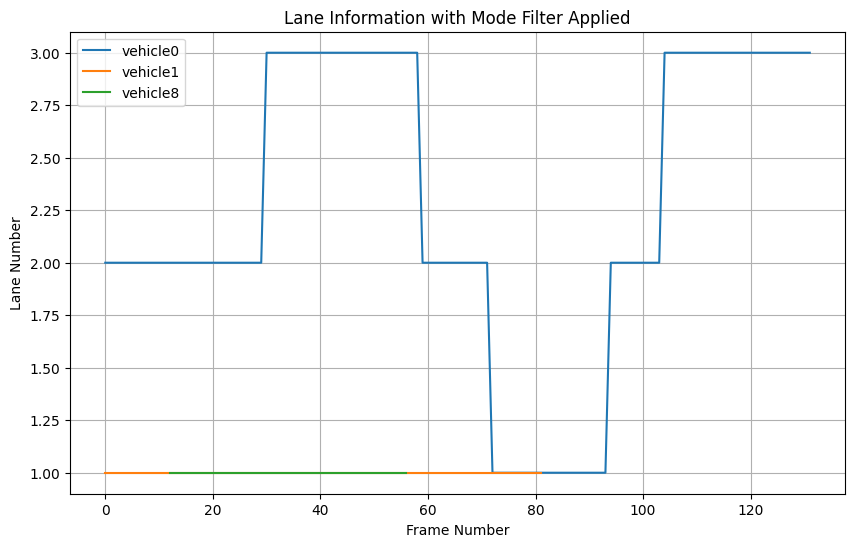

{'vehicle0': [[0, 2, 0.718815499948842, 0.2811845000511582], [1, 2, 0.7229642143129069, 0.2770357856870932], [2, 2, 0.7309197746047337, 0.26908022539526644], [3, 2, 0.74203249601861, 0.2579675039813901], [4, 2, 0.74203249601861, 0.2579675039813901], [5, 2, 0.7554202492833699, 0.24457975071663013], [6, 2, 0.770062691293672, 0.22993730870632806], [7, 2, 0.7849289854701951, 0.21507101452980512], [8, 2, 0.7990842316208984, 0.20091576837910166], [9, 2, 0.8118193221324836, 0.18818067786751658], [10, 2, 0.8227056791962736, 0.17729432080372656], [11, 2, 0.8316281412362803, 0.16837185876371974], [12, 2, 0.8387699836524669, 0.16123001634753314], [13, 2, 0.8445410095021585, 0.15545899049784162], [14, 2, 0.8494676069062383, 0.15053239309376193], [15, 2, 0.8541061751423751, 0.145893824857625], [16, 2, 0.8541061751423751, 0.145893824857625], [17, 2, 0.858916647003533, 0.14108335299646713], [18, 2, 0.8641838695541945, 0.13581613044580554], [19, 2, 0.8699554019196261, 0.13004459808037405], [20, 2, 0.8

In [48]:
from scipy.stats import mode
import matplotlib.pyplot as plt

def mode_filter(data, window_size=5):
    # 결과를 담을 사전
    filtered_data = {}

    for vehicle, values in data.items():
        lanes = [entry[1] for entry in values]
        
        # 모드 필터를 적용
        filtered_lanes = []
        for i in range(len(lanes)):
            # 현재 값 주변의 값들을 윈도우로 선택
            start = max(0, i - window_size // 2)
            end = min(len(lanes), i + window_size // 2 + 1)
            window = lanes[start:end]
            
            # 윈도우 내에서 가장 빈도가 높은 값(모드) 계산
            most_common_result = mode(window, keepdims=True)  # keepdims=True 옵션 추가
            most_common = most_common_result.mode[0]  # 배열 형태로 반환되므로 안전하게 인덱싱 가능
            filtered_lanes.append(int(most_common))
        
        # 필터링된 결과를 데이터에 반영
        filtered_data[vehicle] = [[values[i][0], filtered_lanes[i]] for i in range(len(values))]

    return filtered_data

with open('lane_ratio_filled.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)

# 모드 기반 필터 적용
filtered_data = mode_filter(data, window_size=5)

# 원본 데이터를 필터링된 값으로 덮어쓰기
for vehicle in data.keys():
    for i in range(len(data[vehicle])):
        data[vehicle][i][1] = filtered_data[vehicle][i][1]

# 그래프 그리기
plt.figure(figsize=(10, 6))
for vehicle, values in data.items():
    frames = [entry[0] for entry in values]
    lanes = [entry[1] for entry in values]
    
    plt.plot(frames, lanes, label=vehicle)

# 그래프 설정
plt.xlabel("Frame Number")
plt.ylabel("Lane Number")
plt.title("Lane Information with Mode Filter Applied")
plt.legend()
plt.grid(True)
plt.show()

print(data)


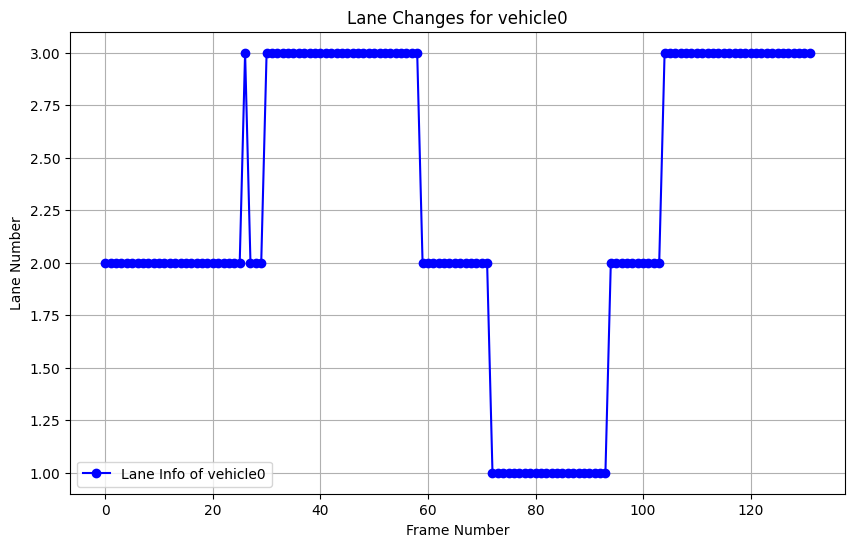

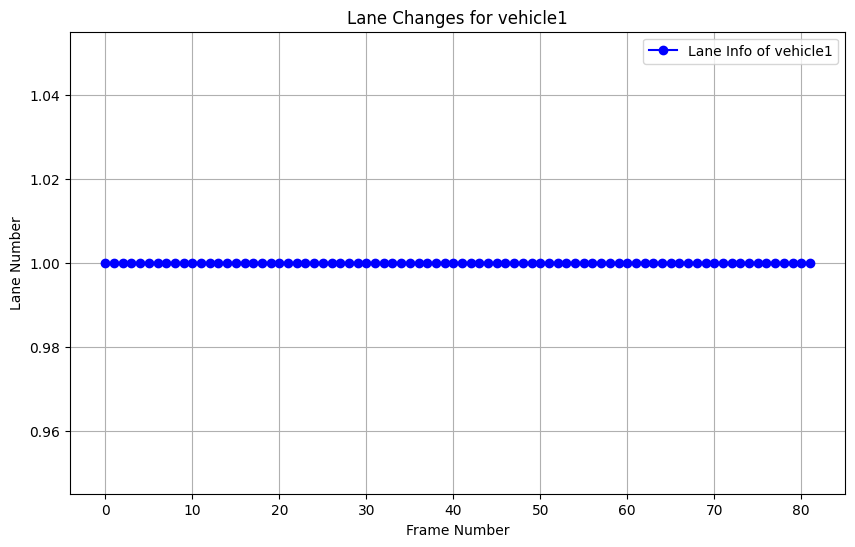

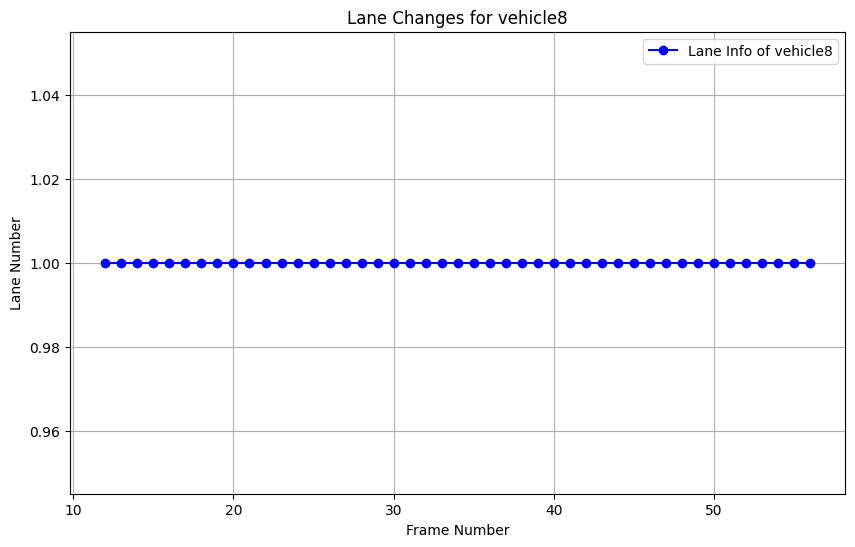

In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np

# JSON 파일에서 데이터를 로드
json_file_path = 'lane_ratio_filled.json'

with open(json_file_path, 'r') as f:
    vehicle_data = json.load(f)

# 차량별로 차선 정보만 추출하고 플로팅하는 함수
def plot_lane_changes_from_file(vehicle_data):
    for vehicle, frames in vehicle_data.items():
        frames = np.array(frames)
        frames_num = frames[:, 0]
        lane_info = frames[:, 1]
        
        plt.figure(figsize=(10, 6))
        plt.plot(frames_num, lane_info, marker='o', linestyle='-', color='b', label=f'Lane Info of {vehicle}')
        
        # 부드러운 곡선을 위해 보간
        # z = np.polyfit(frames_num, lane_info, 3)
        # p = np.poly1d(z)
        # plt.plot(frames_num, p(frames_num), "r--", label='Smoothed Curve')
        
        plt.xlabel('Frame Number')
        plt.ylabel('Lane Number')
        plt.title(f'Lane Changes for {vehicle}')
        plt.legend()
        plt.grid(True)
        plt.show()

# JSON 파일의 데이터를 사용하여 차선 정보 플로팅
plot_lane_changes_from_file(vehicle_data)


In [ ]:
import json
import numpy as np
import math

def adjust_short_lanes(vehicle_data, min_length=4):
    adjusted_data = {}

    for vehicle, frames in vehicle_data.items():
        frames = np.array(frames)
        lane_info = frames[:, 1]
        adjusted_lane_info = list(lane_info.copy())

        start_idx = 0
        while start_idx < len(lane_info):
            current_lane = lane_info[start_idx]
            end_idx = start_idx + 1

            # Find how long the vehicle stays in this lane
            while end_idx < len(lane_info) and lane_info[end_idx] == current_lane:
                end_idx += 1

            # Check if the segment is shorter than or equal to the threshold
            if end_idx - start_idx <= min_length:
                # Replace this segment with the previous lane value, if possible
                if start_idx > 0:
                    previous_lane = adjusted_lane_info[start_idx - 1]
                    for i in range(start_idx, end_idx):
                        adjusted_lane_info[i] = previous_lane

            start_idx = end_idx

        # Replace the original lane info with the adjusted lane info
        adjusted_data[vehicle] = [list(frame) for frame in frames]
        for i in range(len(adjusted_data[vehicle])):
            adjusted_data[vehicle][i][1] = adjusted_lane_info[i]
    
    return adjusted_data

vehicle_data = adjust_short_lanes(vehicle_data)

def clean_quick_reversions(frames, lane_info):
    cleaned_lane_info = list(lane_info)
    i = 0
    while i < len(lane_info) - 1:
        current_lane = lane_info[i]
        j = i + 1

        while j < len(lane_info) and lane_info[j] == current_lane:
            j += 1

        # Check if the lane change reverted back within 5 frames
        if j < len(lane_info) - 1 and j - i <= 50 and lane_info[j] == current_lane:
            # If reverted within 5 frames, treat as if the vehicle never left the lane
            cleaned_lane_info[i:j] = [current_lane] * (j - i)

        i = j

    return cleaned_lane_info

def find_lane_change_midpoints(vehicle_data):
    midpoints = {}

    for vehicle, frames in vehicle_data.items():
        frames = np.array(frames)
        lane_info = frames[:, 1]

        # Clean up lane_info to remove quick reversions
        cleaned_lane_info = clean_quick_reversions(frames[:, 0], lane_info)

        midpoints_for_vehicle = []
        start_frame = None
        start_lane = cleaned_lane_info[0]


        for i in range(1, len(frames)):
            current_lane = cleaned_lane_info[i]
            if current_lane != start_lane:
                if start_frame is not None:
                    end_frame = i
                    midpoint_frame = (start_frame + end_frame) // 2
                    midpoints_for_vehicle.append({
                        'start_lane': int(start_lane),
                        'end_lane': int(current_lane),
                        'enter_time': round(start_frame/15,2),
                        'leave_time': round(end_frame/15,2),
                        'midpoint_time': round(midpoint_frame/15,2)
                    })

        
                start_frame = i  # Update start_frame for the next lane change
                start_lane = current_lane  # Update start_lane to the new lane
        if len(midpoints_for_vehicle)!=0:
            midpoints_for_vehicle.insert(0,{
                            'start_lane': int(vehicle_data[vehicle][0][1]),
                            'end_lane': midpoints_for_vehicle[0]['start_lane'],
                            'enter_time': 0,
                            'leave_time': midpoints_for_vehicle[0]['enter_time']/15,
                            'midpoint_time': midpoints_for_vehicle[0]['enter_time']/30
                        })
        if len(midpoints_for_vehicle)==0:
            midpoints_for_vehicle.append({
                            'start_lane': int(vehicle_data[vehicle][0][1]),
                            'end_lane': -1,
                            'enter_time': 0,
                            'leave_time': 10,
                            'midpoint_time': 5
                        })
        
        midpoints[vehicle] = midpoints_for_vehicle


    
    return midpoints

# Calculate lane change midpoints
lane_change_midpoints = find_lane_change_midpoints(vehicle_data )

# Display lane change midpoints for each vehicle
import pprint
pprint.pprint(lane_change_midpoints)


In [52]:
import json
# Define the path where you want to save the JSON file
json_file_path = 'lane_change_midpoints.json'

# Open the file in write mode and dump the data
with open(json_file_path, 'w') as json_file:
    json.dump(lane_change_midpoints, json_file, indent=4)

print(f"Data has been saved to {json_file_path}")

Data has been saved to lane_change_midpoints.json
